In [1]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
import matplotlib.pyplot as plt

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

from nixtla.models.esrnn.esrnn import ESRNN

In [2]:
from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df = EPF.load(directory='data', group=EPFInfo.groups[0])
# Y_df = Y_df.head(365*24)
# X_df = X_df.head(365*24)
X_df = X_df[['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day']]

epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_in_test=24)
epf_dataset_full = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_in_test=0)

Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2018-12-24 2018-12-24 23:00:00
          1.0         2013-01-01 2018-12-23 23:00:00
Total data 			52416 time stamps
Available percentage=100.0, 	52416 time stamps
Train percentage=99.95, 	52392.0 time stamps
Outsample percentage=0.05, 	24.0 time stamps


Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        1.0         2013-01-01 2018-12-24 23:00:00
Total data 			52416 time stamps
Available percentage=100.0, 	52416 time stamps
Train percentage=100.0, 	52416.0 time stamps
Outsample percentage=0.0, 	0.0 time stamps




In [3]:
train_loader = TimeSeriesLoader(ts_dataset=epf_dataset,
                                model='esrnn',
                                offset=0,
                                window_sampling_limit= 24*30,
                                input_size=7*24,
                                output_size=24,
                                idx_to_sample_freq=1,
                                complete_inputs=True,
                                complete_sample=False,
                                batch_size=1,
                                shuffle=True)
test_loader = TimeSeriesLoader(ts_dataset=epf_dataset_full,
                                model='esrnn',
                                offset=0,
                                window_sampling_limit= 24*30,
                                input_size=7*24,
                                output_size=24,
                                idx_to_sample_freq=24,
                                complete_inputs=True,
                                complete_sample=False,
                                batch_size=1,
                                shuffle=True)

In [4]:
esrnn = ESRNN(input_size=7*24,
              output_size=24,
              include_var_dict={'Exogenous1':[-8,-2,-1], 'Exogenous2':[-8,-2,-1], 'week_day':[-1]},
              t_cols=epf_dataset.t_cols,
              max_epochs=50,
              learning_rate=1e-3,
              lr_scheduler_step_size=9,
              lr_decay=0.9,
              per_series_lr_multip=1.0,
              gradient_eps=1e-8,
              gradient_clipping_threshold=20,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=200,
              testing_percentile=50,
              training_percentile=50,
              cell_type='LSTM',
              state_hsize=40,
              dilations=[[1, 2], [4, 8]],
              add_nl_layer=False,
              seasonality=[24, 168],
              random_seed=1,
              device='cpu')

In [5]:
esrnn.fit(train_ts_loader=train_loader, eval_epochs=1)

self.n_t 145
Infered frequency: H
=============== Training ESRNN  ===============

Epoch: 0, Time: 1.056, Insample loss: 0.17714
Epoch: 1, Time: 2.145, Insample loss: 0.17144
Epoch: 2, Time: 3.319, Insample loss: 0.16672
Epoch: 3, Time: 4.490, Insample loss: 0.16255
Epoch: 4, Time: 5.676, Insample loss: 0.15902
Epoch: 5, Time: 6.942, Insample loss: 0.15596
Epoch: 6, Time: 8.190, Insample loss: 0.15345
Epoch: 7, Time: 9.433, Insample loss: 0.15129
Epoch: 8, Time: 10.750, Insample loss: 0.14964
Epoch: 9, Time: 11.974, Insample loss: 0.14841
Epoch: 10, Time: 13.170, Insample loss: 0.14752
Epoch: 11, Time: 14.437, Insample loss: 0.14672
Epoch: 12, Time: 15.792, Insample loss: 0.14592
Epoch: 13, Time: 17.056, Insample loss: 0.14514
Epoch: 14, Time: 18.337, Insample loss: 0.14433
Epoch: 15, Time: 19.751, Insample loss: 0.14351
Epoch: 16, Time: 21.085, Insample loss: 0.14265
Epoch: 17, Time: 22.415, Insample loss: 0.14183
Epoch: 18, Time: 23.870, Insample loss: 0.14111
Epoch: 19, Time: 25.232

In [6]:
y_true, y_hat, y_mask = esrnn.predict(ts_loader=test_loader, eval_mode=True)

In [7]:
y_hat_flatten = y_hat[:,-14:,:].flatten()
y_hat_flatten.shape

(336,)

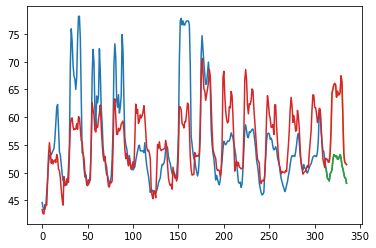

In [8]:
y_plot = Y_df['y'][-14*24:]
y_hat_plot = y_hat[0,-1,:]
plt.plot(range(len(y_plot)), y_plot)
plt.plot(range(len(y_plot)-len(y_hat_plot),len(y_plot)), y_hat_plot)
plt.plot(range(len(y_plot)-len(y_hat_plot),len(y_plot)), y_true[0,-1,:])
plt.plot(range(len(y_hat_flatten)), y_hat_flatten)

# WEEKLY M4 WITH RANDOM STATIC

In [ ]:
from nixtla.data.datasets.m4 import M4, M4Info
group = M4Info.groups[3]
print("M4Info.groups[3]", group)
Y_df = M4.load(directory='data', group=group)

S_df = Y_df.copy()
S_df = S_df.drop_duplicates(subset='unique_id').reset_index(drop=True)
S_df = S_df.drop(columns=['ds','y'])
np.random.seed(1)
S_df['static1'] = np.random.randint(low=0, high=1000, size=len(S_df))
S_df['static2'] = np.random.randint(low=0, high=1000, size=len(S_df))
S_df['static3'] = np.random.randint(low=0, high=1000, size=len(S_df))
S_df['static4'] = np.random.randint(low=0, high=1000, size=len(S_df))
S_df['static5'] = np.random.randint(low=0, high=1000, size=len(S_df))

In [ ]:
tourism_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=None, S_df=S_df, ts_in_test=13)

In [ ]:
train_loader = TimeSeriesLoader(ts_dataset=tourism_dataset,
                                model='esrnn',
                                offset=0,
                                window_sampling_limit=500*4, 
                                input_size=13,
                                output_size=13,
                                idx_to_sample_freq=1,
                                batch_size= 32,
                                n_series_per_batch=32,
                                complete_inputs=False,
                                complete_sample=False,
                                shuffle=False)

In [ ]:
esrnn = ESRNN(input_size=13,
              output_size=13,
              max_epochs=5,
              freq_of_test=-1,
              learning_rate=1e-3,
              lr_scheduler_step_size=9,
              lr_decay=0.9,
              per_series_lr_multip=1.0,
              gradient_eps=1e-8,
              gradient_clipping_threshold=20,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=200,
              testing_percentile=50,
              training_percentile=50,
              cell_type='LSTM',
              state_hsize=40,
              dilations=[[1, 2], [4, 8]],
              add_nl_layer=False,
              seasonality=[],
              random_seed=1,
              device='cpu')

In [ ]:
esrnn.fit(train_ts_loader=train_loader, eval_epochs=1)

In [ ]:
y_hat = esrnn.predict(ts_loader=train_loader)

In [ ]:
y_plot = Y_df[Y_df['unique_id']=='W100']['y']
y_hat_plot = y_hat[y_hat['unique_id']=='W100']['y_hat']
plt.plot(range(len(y_plot)), y_plot)
plt.plot(range(len(y_plot), len(y_plot)+len(y_hat_plot)), y_hat_plot)

In [ ]:
y_test = Y_df.groupby('unique_id').tail(13).reset_index(drop=True)
np.mean(np.abs(y_test['y']-y_hat['y_hat'])/np.abs(y_test['y']))